In [1]:
import sys
import os
import tarfile

import h5py as h5
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sys.path.append('../dev')
import predict
import downloader

Using TensorFlow backend.


In [10]:
try:
    DOCKER = get_ipython().magic('env')['DOCKER']
except:
    DOCKER = None
if not DOCKER:
    downloader.download_figshare(15483431,'../data/data.tar.gz')

tar = tarfile.open('../data/data.tar.gz')
tar.extractall(path='../')

File name: data.tar.gz
File size: 112.61MB
Locating file...
Done!
100.00%
Done!


# 1. Introdução

Neste trabalho, propõe-se a implementação de uma rede neural convolucional que efetua a super-resolução de uma imagem bidimensional. 

A aplicação final dessa metodologia será tornar factível a reconstrução tomográfica de um imagem, que seria impraticável em condições normais, devido à alta resolução da imagem final.

Um exemplo disto é o caso de imageamento por difração coerente (CDI em inglês). Para a reconstrução de grandes volumes, e para que estas sejam feitas em tempo hábil, é necessário que isso seja feito com o auxílio do poder de processamento paralelo de GPUs. A contrapartida é que a memória disponível nas GPUs disponíveis no mercado atualmente limita as dimensões deste volume. Entretanto, neste trabalho, serão utilizados volumes de imagens com dimensões limitadas, em comparação com as amostras coletadas originalmente, para fins de demonstração.

Em tese, não há um limite bem definido para qual resolução física uma imagem pode ser super-resolvida. No entanto, para que se obtenha dados mais próximos do real, a resolução do _upscaling_ é limitada por uma correlação denominada FSC -- Fourier Shell Correlation.

Para fins de demonstração, neste trabalho, será aplicada a super-resolução em escala de 2 vezes, ou seja, para o dobro da resolução da imagem de entrada.

Apesar de dados tomográficos serem tridimensionais, a princípio, a técnica será aplicada em cada imagem (2D) que compõe um volume (3D) -- as fatias -- pois muitas análises e técnicas de segmentação também são feitas sobre as fatias. 

# 2. Materiais e métodos

## 2.1. Dados experimentais

Os dados iniciais consistem de experimentos de tomografia computadorizada, realizados na linha de luz IMX do Laboratório Nacional de Luz Síncrotron em que foram adquiridas projeções em variados ângulos. São 3 amostras de diferentes objetos.

As medidas foram realizadas nos seguintes objetos:
- Ponta de caneta esferográfica;
- Palito de madeira;
- Espinho de planta;

Originalmente, as medidas de cada amostra resultaram em projeções de 2048 ângulos, com cada projeção tendo dimensões de 2048 pixels de altura, 2048 pixels de largura e 8 bits de profundidade. 

Estas projeções são os dados brutos que, em seu estado original, acabam resultando em arquivos de aproximadamente 8 gigabytes ($(2048\times2048\times2048\times2)/(1024^3)=8GB$). 

Para processar esses dados, seriam necessários recursos de memória, processamento e armazenamento impraticáveis para a disciplina, principalmente para que a reprodutibilidade seja possível para todos os colegas.

Portanto, para fins de experimento e de reprodutibilidade para a disciplina, foi feita uma subamostragem dos dados brutos. Todos foram reduzidos para 512 ângulos e 512 pixels de altura e largura, resultando em arquivos de aproximadamente 250MB.



### 2.1.1. Dados brutos

Os dados brutos são gravados em um arquivo com nome padrão, _tomo.h5_. Abaixo pode ser verificada uma projeção da amostra. Esses dados serão disponibilizados apenas para fins informativos, pois os dados reconstruídos estarão todos disponíveis para _download_.

A reconstrução desses dados requer um software especial para tal fim, portanto esse procedimento não será contemplado por este trabalho.

<img src="../figures/projection_256.png" width="50%">

<i><center>Figura 1: Projeção do ângulo 256 da amostra.</center></i>

<img src="../figures/sinogram_256.png" width="50%">

<i><center>Figura 2: Sinograma da linha 256 do dado bruto.</center></i>

### 2.1.2. Reconstrução
Após adquiridas as projeções, é necessário realizar a reconstrução tomográfica, para que se possa obter as imagens tridimensionais das amostras. 

Com o método de reconstrução tomográfica utilizado, é gerado um arquivo por fatia do volume tridimensional. Nas dimensões apresentadas, cada arquivo tem tamanho aproximado de 260 kilobytes. Para eliminar a necessidade de manter muitos arquivos, posteriormente fez-se um processamento para que as fatias sejam mantidas em um único arquivo.

Abaixo pode-se verificar a visualização de uma projeção e o corte em diferentes ângulos da imagem reconstruída.

Para evitar uma grade quantidade de arquivos, optou-se por criar um único arquivo contendo todas as fatias. O formato utilizado foi o HDF5, que é de simples utilização e pode ser manipulado por bibliotecas python.

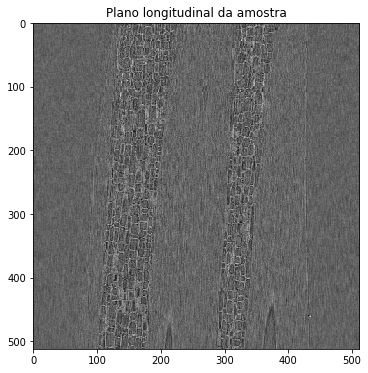

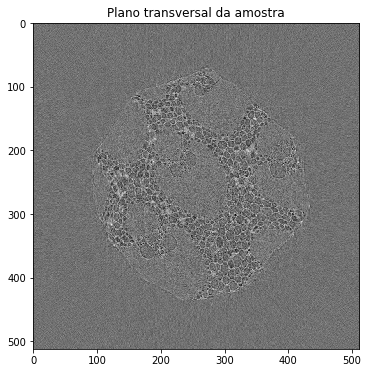

In [11]:
%matplotlib inline
with h5.File('../data/ground_data/ground_data_pick.h5', 'r') as h5file:
    cut_l = h5file['data']
    predict.bigshow(cut_l[:, 256, :], 'Plano longitudinal da amostra', size=6)
    predict.bigshow(cut_l[256, :, :], 'Plano transversal da amostra', size=6)
del h5file

### 2.1.3. Preparação dos dados

Para treino e validação da rede, primeiramente os dados sub-amostrados foram re-escalados para as dimensões das imagens _ground truth_, com interpolação bicúbica. A partir de então, foram geradas bases de dados contendo fragmentos de dimensões menores às das imagens de entrada e saída, para dado e anotação.

Grande parte do código foi baseada em um código escrito anteriormente, mas para diferentes tipos de dados. Portanto, muitas adaptações tiveram de ser feitas.

Foram 2 situações diferentes de extração de fragmentos:
1. Fragmentos de 32x32 pixels para dado de treinamento e 20x20 pixels para as _labels_.
2. Fragmentos de 64x64 pixels para dado de treinamento e 52x52 pixels para as _labels_.

Esse redimensionamento para as _labels_ teve de ser efetuada porque na primeira e terceira camadas convolucionais foi utilizado o modo _valid_ que remove as bordas afetadas pelo efeito de borda da convolução.

Como havia 3 amostras tridimensionais, 2 foram utilizadas para fazer o treino e validação, e uma foi mantida para o teste.

## 2.2. Metodologia

Esta seção descreve os métodos utilizados para a implementação da rede neural convolucional.

A seção 2.2.1 contém uma descrição geral do conceito de _upscaling_, que é o objetivo final do algoritmo. A seção 2.2.2 apresenta uma breve introdução sobre redes neurais convolucionais e, finalmente, a seção 2.2.3 descreve brevemente a arquitetura da rede utilizada neste trabalho, SRCNN. O modelo finalmente escolhido, dentre as variações da SRCNN foi denominado, neste trabalho, 9-3-5, como poderá ser visto ao longo dos próximos tópicos deste trabalho.

### 2.2.1. _Upscaling_

As reconstruções apresentadas são as imagens em resultado ideal, com a resolução que se espera alcançar com o experimento proposto por este projeto.

Para o experimento, foram feitas subamostragens dos dados brutos que, por sua vez, passaram pela reconstrução tomográfica, que então foram submetidas ao processo de _upscaling_.

Ao final, os dados reconstruídos são volumes de 512 pixels cúbicos, para as imagens _ground truth_ e 256 pixels cúbicos para as as imagens reconstruídas a partir do dado subamostrado. Ou seja, reconstruções na escala maior, com 512x512x512 pixels serviram como _ground truth_ para a rede convolucional utilizada.

### 2.2.2. Redes Neurais Convolucionais

Redes neurais convolucionais (CNN na sigla em inglês), assim como outras redes neurais artificiais, são baseadas em observações na natureza. Neste caso, especificamente, na arquitetura do córtex visual de seres capazes de enxergar. 

Experimentos realizados com algumas espécies de animais concluíram que os neurônios responsáveis pelo processamento visual apenas reagem a estímulos em regiões limitadas do campo visual.

Neste sentido, assim como a percepção visual observada nesses experimentos, em uma rede neural convolucional, os neurônios de uma camada não estão conectados a todos os neurônios da camada anterior, mas em uma região de interesse, limitada pela arquitetura da rede.

### 2.2.3. SRCNN

O objeto de estudo deste trabalho é uma rede convolucional específica, criada para realizar _upscaling_ de imagens. Esta rede, chamada _Super-resolution Convolutional Neural Network_, SRCNN, por Dong et al [2] foi criada com o intuito de melhorar a resolução de imagens comuns, não direcionada exatamente para imagens tomográficas, o que pode fazer com que a rede necessite de ajustes para que funcione como o esperado para os dados deste trabalho.

Esta é uma rede convolucional relativamente simples. Ela contém apenas 3 camadas convolucionais, com ativação _rectified linear unit_, ReLU. A otimização utilizada originalmente pelo autor foi a descida de gradiente estocástica, mas como poderá ser observado, a otimização Adam se mostrou mais efetiva para esta aplicação, através dos experimentos.


<img src="../figures/srcnn_layers.png" width="70%">

<i><center>Figura 1: Arquitetura da SRCNN: 3 camadas convolucionais. Fonte: Dong et al [2] </center></i>

Como ilustrado na Figura 1, a rede foi desenhada de forma que cada uma das 3 camadas tivesse uma função bem definida:

* **Extração de retalhos e representação:** operação que extrai retalhos, como vetores de características da imagem, sendo que os vetores podem ter áreas de sobreposição entre eles.
* **Mapeamento não-linear:** mapeamento entre os vetores de características de entrada e saída.
* **Reconstrução:** geração da saída da rede, que deverá ser a imagem mais próxima à do _ground truth_.


Para a rede convolucional, como também demonstrado por Dong _et al_, variações nas dimensões do filtro da segunda camada também poderia ter influência no resultado, que também foram testadas para que fosse encontrado o melhor modelo. Foram feitas, basicamente, as 3 variações de tamanho de filtro em cada camada, mencionadas pelo autor:

* **9-1-5:** filtros 9x9 com 128 mapas de características, 1x1 com 64 mapas de características e 5x5;
* **9-3-5:** filtros 9x9 com 128 mapas de características, 3x3 com 64 mapas de características e 5x5;
* **9-5-5:** filtros 9x9com 128 mapas de características, 5x5 com 64 mapas de características, e 5x5;

A métrica utilizada para visualização do resultado, a princípio, foi o erro quadrático médio, mas pôde-se verificar que esta pode não ser a melhor alternativa para o tipo de dado utilizado e gerado.

Seguindo o exemplo de Dong _et al_, também foi feita a medida da relação sinal-ruído de pico, PSNR, mas o resultado não se mostrou muito representativo.

Uma métrica mais apropriada, utilizada posteriormente, e que pode refletir bem a semelhança entre a saída e o _ground truth_, foi o índice de similaridade estrutural (SSIM). Essa métrica reflete no índice de similaridade entre as imagens, variando de 0 a 1, em que 0 significa nada similar e 1 totalmente similar (idêntico).

Além dos cenários descritos anteriormente, também foram feitos experimentos com variações de arquitetura. Algumas delas foram:

* Variação nas dimensões das camadas: essa variação resultou em um modelo não satisfatório. Visualmente, as predições não apresentavam nenhuma similaridade com o _ground truth_. Após 100 épocas, o modelo convergiu sem predições significativas.
* Convolução no modo "_same_" para todas as camadas: para tanto, também foi necessário gerar os dados de _ground truth_ com as dimensões corretas (mesmas dimensôes de entrada). Essa variação se apresentou levemente mais lenta, mas também resultou em predições não satisfatórias em comparação com as outras arquiteturas. Após 100 épocas, o modelo convergiu.

# 3. Resultados

Após os experimentos, o treinamento das redes e a escolha do melhor modelo, foi possível, então, verificar os resultados na base de dados de teste.

Os gráficos desta seção ilustram os resultados de treinamento. A variação que apresentou o melhor resultado foi a denominada 9-3-5, como poderá ser verificado a seguir.

## 3.1. Rede 9-1-5

Esta rede apresentou um comportamento não esperado, pois, após 50 épocas, o SSIM passou a decair rapidamente, chegando a 0.65 após 300 épocas.

<img src="../figures/9-1-5.png" width="70%">

<i><center>Figura: SSIM x Épocas com a rede 9-1-5.</center></i>

## 3.2. Rede 9-5-5

Esta rede, após 100 épocas, apresentou SSIM de 0.95. Esta rede apresentou resultados visualmente melhores, mas foi mais lenta (aproximadamente 8 horas para 600 épocas) e se mostrou inferior á rede 9-3-5, como discutido a seguir. Os resultados estão ilustrados abaixo.

## 3.3. Rede 9-3-5

Esta rede, após 80 épocas, apresentou SSIM acima de 0.96. Os resultados desta rede, comparados com as outras, foram mais satisfatórios, mas não se aproximam significativamente do _ground truth_.

<img src="../figures/9-3-5.png" width="70%">

<i><center>Figura: SSIM x Épocas com a rede 9-3-5.</center></i>

Em todo caso, este foi o melhor modelo nas bases de treino, por este motivo, foi também aplicado na base de teste, como pode ser verificado a seguir.

Abaixo é possível visualizar os resultados da rede 9-3-5 na amostra utilizada para teste.

As imagens abaixo representam a fatia 256 do volume, também foram selecionadas 20 fatias adicionais para a predição, que poderão ser visualizadas em seguida:

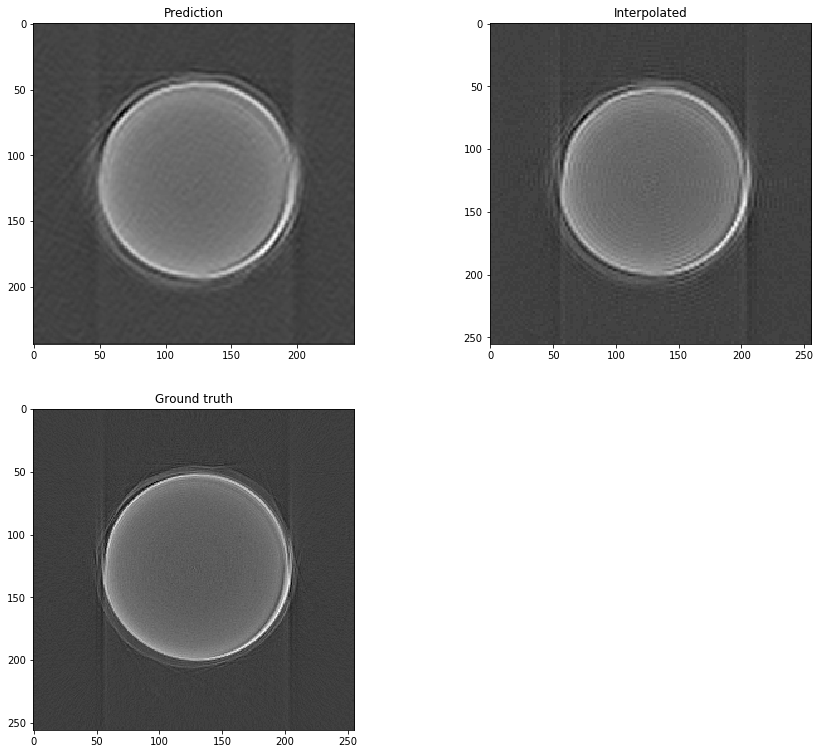

In [14]:
%matplotlib inline
slice_num = 256
prediction, label, interpolated = predict.show_slice(slice_num, amount_slices=20,
                                                     gt_data='../data/ground_data/ground_data_pen.h5', 
                                                     data='../data/sub_data/sub_data_pen.h5')

Abaixo é possível navegar pelo volume selecionado, com 20 fatias adicionais, além da fatia número 256. A primeira imagem é uma comparação entre o resultado da predição com o modelo treinado (esquerda e acima) e o _ground truth_ (direita); e também modelo treinado (esquerda e abaixo) com a super resolução por interpolação bicúbica (direita e abaixo):

In [ ]:
%matplotlib notebook
%matplotlib notebook
print('USE THE MOUSE SCROLLING WHEEL TO NAVIGATE OVER THE SLICES.')

predict.multi_slice_viewer(prediction[:, :, :, 0].transpose(), label.transpose())

print('USE THE MOUSE SCROLLING WHEEL TO NAVIGATE OVER THE SLICES.')

predict.multi_slice_viewer(prediction[:, :, :, 0].transpose(), interpolated.transpose())

In [ ]:
print('USE THE MOUSE SCROLLING WHEEL TO NAVIGATE OVER THE SLICES.')

predict.multi_slice_viewer(prediction[:, :, :, 0], label)

print('USE THE MOUSE SCROLLING WHEEL TO NAVIGATE OVER THE SLICES.')
predict.multi_slice_viewer(prediction[:, :, :, 0], interpolated)

# 3. Conclusões e trabalhos futuros


Com os resultados obtidos neste trabalho, pode-se verificar que é possível treinar uma rede para obter bons resultados de super resolução em imagens tomográficas. Foi possível concluir que é possível obter resultados satisfatórios, mas que, para tanto, deve-se considerar pontos importantes como:

* Ajustes na rede: ajustes como alteração nas dimensões de filtros e mapas de características e inserção de mais camadas convolucionais ou de pooling poderiam contribuir positivamente para a arquitetura desta rede, nesta aplicação.
* Outras arquiteturas: testar outras arquiteturas de redes de deep learning podem ser benéficas para esse tipo de trabalho, pois é possível que outras propostas sejam mais adequadas para o tipo de dado apresentado.
* Maior variedade de dados: os dados utilizados apresentam pouca variação. Isso afeta o modelo negativamente, que pode apresentar overfitting devido aos dados muito uniformes enre si.
* Função de custo: a função de custo utilizada não se mostrou relevante, já que, para o tipo de dado utilizado, existem outras métricas mais apropriadas.


# Referências

[1] Elias Nehme, Lucien E. Weiss, Tomer Michaeli, and Yoav Shechtman, "Deep-STORM: super-resolution single-molecule microscopy by deep learning," Optica 5, 458-464 (2018)

[2] C. Dong, C. C. Loy, K. He, and X. Tang, “Image super-resolution using deep convolutional networks,”IEEE Transactions on Pattern Analysisand Machine Intelligence, vol. 38, pp. 295–307, Feb 2016.

[3] A C Kak and M Slaney. Principles of Computerized Tomographic Imaging. IEEE Press, New York, NY, 1988.

[4] “Sirius, a nova fonte de luz sıncrotron brasileira.”https://www.lnls.cnpem.br/sirius/projeto-sirius/

[5]  M. van Heel and M. Schatz, “Fourier shell correlation threshold criteria,”Journal of Structural Biology, vol. 151, no. 3, pp. 250 – 262, 2005.

[6] Aurlien Gron. 2017. Hands-On Machine Learning with Scikit-Learn and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems (1st ed.). O'Reilly Media, Inc.

[7] HUBEL, D H. “Single unit activity in striate cortex of unrestrained cats.” The Journal of physiology vol. 147,2 (1959): 226-38.

[8] Kingma, D. P. and Ba, J. (2014). Adam: A Methodfor Stochastic Optimization.arXiv e-prints, pagearXiv:1412.6980.